Today I'm adding "time in range" to my daily stats. Time in range means: how much time was Alma's glucose within her (current) target range of 70-180 mg/dL? 

In [1]:
# IMPORTS

# since this notebook lives in a sub-folder of the main project, I'll add the main folder to the python path
import sys
sys.path.append("../")

# Load my modules
from tools.glooko import read_all
from tools.stats import get_yeardays

# Load extra stuff that I need
import numpy as np
import pandas as pd

# Plotting (matplotlib widge allows for interactivity in the live notebook)
import matplotlib.pyplot as plt
%matplotlib widget


In [2]:
# GET UNIQUE DAYS

df_cgm, df_bolus, df_basal, df_insulin = read_all(r"../data")
df_cgm["yearday"] = get_yeardays(df_cgm)
df_insulin["yearday"] = get_yeardays(df_insulin)

# COMPUTE STATS PER DAY
df_cgm.drop("sn_cgm", axis=1, inplace=True)
df_cgm_summary = df_cgm[["bg", "yearday"]].groupby("yearday").describe()["bg"]

df_cgm_summary["yearday"] = df_cgm_summary.index
df_cgm_summary["time"] = pd.to_datetime(df_cgm_summary['yearday'], format='%Y-%j')

In [3]:
# COMPUTE DAILY TIME IN RANGE
min_target = 70
max_target = 180

unique_days = df_cgm_summary["yearday"].tolist()

# Initialize lists
pct_above = []
pct_below = []
pct_inrange = []

# loop through each day (I'm sure there's a fancy way to do this with Pandas but I 
# can't figure it out...)
for day in unique_days:
    df_sub = df_cgm[df_cgm["yearday"]==day]
    this_total = len(df_sub)
    if this_total > 0:
        pct_above.append(sum(df_sub["bg"]>max_target)/this_total*100)
        pct_below.append(sum(df_sub["bg"]<=min_target)/this_total*100)
        pct_inrange.append(sum((df_sub["bg"] > min_target) & (df_sub["bg"] <= max_target))/this_total*100)
    else:
        pct_above.append(0)
        pct_below.append(0)
        pct_inrange.append(0)
        
df_cgm_summary["pct_above"] = pct_above
df_cgm_summary["pct_below"] = pct_below
df_cgm_summary["pct_inrange"] = pct_inrange

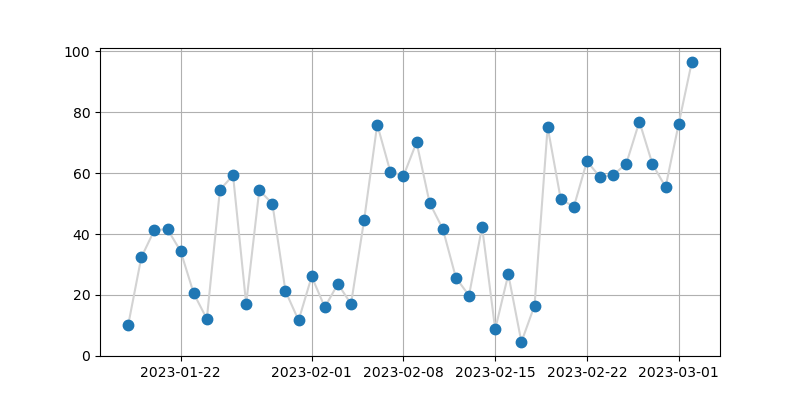

In [4]:
## Plotting percent time in range
fig,ax = plt.subplots(1,1, figsize=(8,4))

ax.plot(df_cgm_summary["time"], df_cgm_summary["pct_inrange"],color="lightgray")
ax.plot(df_cgm_summary["time"], df_cgm_summary["pct_inrange"],'.', markersize=15)
plt.grid()

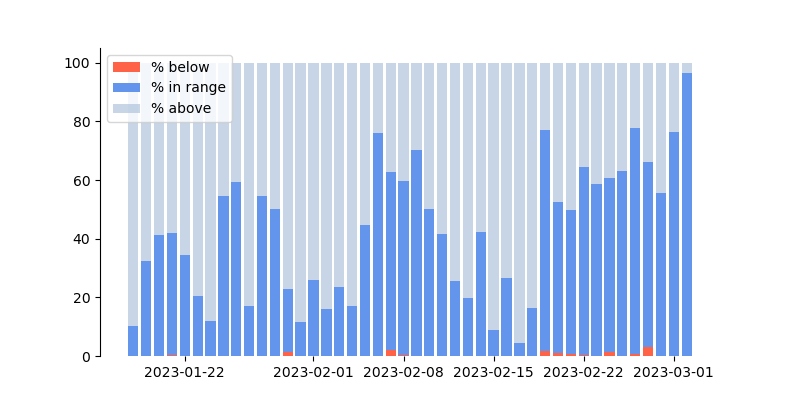

In [17]:
## Bar plot
import seaborn as sns

fig2, ax2 = plt.subplots(1,1, figsize=(8,4))

ax2.bar(df_cgm_summary["time"], df_cgm_summary["pct_below"], 
        color="tomato", alpha=1, label="% below")

ax2.bar(df_cgm_summary["time"], df_cgm_summary["pct_inrange"], 
        bottom=df_cgm_summary["pct_below"],
        color="cornflowerblue", alpha=1, label="% in range")

ax2.bar(df_cgm_summary["time"], df_cgm_summary["pct_above"], 
        bottom=df_cgm_summary["pct_below"] + df_cgm_summary["pct_inrange"],
        color="lightsteelblue", alpha=0.7, label="% above")

ax2.spines[['right', 'top']].set_visible(False)

ax2.legend(ncol=1)
sns.despine(left=False, bottom=True,ax=ax2)

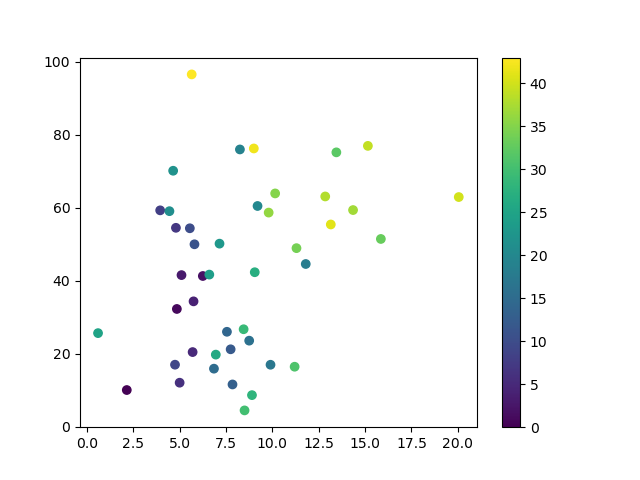

In [34]:
fig3, ax3 = plt.subplots(1,1)

df_cgm_summary["daynum"] = np.arange(0,len(df_cgm_summary))

plt.scatter(df_insulin["total_insulin"][::-1], 
            df_cgm_summary["pct_inrange"], 
            c=df_cgm_summary["daynum"])

plt.colorbar()


In [30]:
df_cgm_summary["daynum"]

yearday
2023-018     0
2023-019     1
2023-020     2
2023-021     3
2023-022     4
2023-023     5
2023-024     6
2023-025     7
2023-026     8
2023-027     9
2023-028    10
2023-029    11
2023-030    12
2023-031    13
2023-032    14
2023-033    15
2023-034    16
2023-035    17
2023-036    18
2023-037    19
2023-038    20
2023-039    21
2023-040    22
2023-041    23
2023-042    24
2023-043    25
2023-044    26
2023-045    27
2023-046    28
2023-047    29
2023-048    30
2023-049    31
2023-050    32
2023-051    33
2023-052    34
2023-053    35
2023-054    36
2023-055    37
2023-056    38
2023-057    39
2023-058    40
2023-059    41
2023-060    42
2023-061    43
Name: daynum, dtype: int64